<div style="margin: 0 auto 30px; height: 60px; border: 2px solid gray; border-radius: 6px;">
  <div style="float: left;"><img src="img/epfl.png" /></div>
  <div style="float: right; margin: 20px 30px 0; font-size: 10pt; font-weight: bold;"><a href="https://moodle.epfl.ch/course/view.php?id=18253">COM202 - Signal Processing</a></div>
</div>
<div style="clear: both; font-size: 30pt; font-weight: bold; color: #483D8B;">
    Lab 5 : Filters for Audio Processing
</div>

# **Introduction**

In this lab, you will delve into the intricacies of digital audio processing by designing, analyzing, and implementing a series of essential filters. Through deriving each filter from its transfer function, visualizing their responses, and applying them to actual sound signals, you'll gain a deeper understanding of both the theoretical foundations and practical nuances of audio effects. This hands-on exploration encourages you to experiment with parameter tuning, bridging the gap between mathematical models and real-world auditory perception.

## Lab Content

In this lab, we will implement some well-known processing algorithm used in music production:

- **Schroeder Reverb**
- **Bass Boosting**
- **Sweep EQ Effect**

For each filter, you will:
1. Build one or more filters based on their transfer function
2. Visualize and analyze frequency responses
3. Apply the filters to a sound and listen to the result

As usual, we start by importing the necessary libraries to ensure the lab runs smoothly.

In [6]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
from scipy.io import wavfile
from IPython.display import Audio

plt.rcParams['figure.figsize'] = 14, 4 # set default size of plots

def load_wav(file):
    sf, x = wavfile.read(f'data/{file}.wav')
    return sf, (x - np.mean(x)) / 32767.0

# **I. Artificial Reverb Effect**

**Artificial reverb** is a technique that simulates the reverberation of a space by combining simple filters. Essentially, by applying a series of filters, we can mimic how sound reflects and diffuses in a room.

## Reverberant rooms

<img width="200" style="float: right; margin: 0 30px 20px 30px;" src="img/reflections.png"> 

A reverberant room acts like a filter whose impulse response is dependent on the geometry of the enclosure, on the materials used for the walls and the objects in the space, and on the positions of both the sound source and of the listener. 

To understand the properties of a room's impulse response (RIR), recall that the sound waves produced by the source will reach the listener multiple times:
 * via a direct path, if source and listener are in a direct line of sight
 * after being reflected once by a wall (first-order or "early" reflections)
 * after multiple reflections by different walls (high-order or late" reflections)

The number of reflections grows exponentially with increasing order and therefore the RIR becomes denser and denser towards its "tail"; at the same time, because of absorption losses, the amplitude of a reflection is an exponentially decreasing function of its order and so the typical time-domain envelope of a RIR is the one shown below:

<img width="600" style="display: block; margin: 40px auto;" src="img/rir.png"> 

## Reverb simulators 

Realistic RIRs are difficult to measure and computationally expensive to implement; an alternative is to use an artificial reverberation algorithm. In this lab, we focus on implementing the **Schroeder Reverb**, one of the first synthetic reverberation examples. The method uses a combination of **comb filters** and **allpass filters** where

- comb filters simulate the **early reflections**.
- all-pass filters simulate the denser, diffused tail.

This combination effectively recreates the natural reverb of a space using a very small amount of computation; 

## Reference and Schematic

Using [this site](https://ccrma.stanford.edu/~jos/pasp/Schroeder_Reverberators.html) as a reference we will implement the following block diagram.

<img width="700" style="display: block; margin: 20px auto;" src="img/schroeder_reverb_stanford.png"> 

In the figure

- $\text{AP}^g_D$ indicates an allpass filter of order $D$ and gain $g$
- $\text{FBCF}^g_N$ indicates a feedback comb filter with a gain equal to $g$ and a delay of $N$ samples.
- **MM** indicates a "Mixing Matrix" but we won't need this element in our implementation

### A) **Allpass Filters**

A filter with transfer function

$$
    P(z) = \frac{z^{-D} - g}{1 - g z^{-D}}
$$

is called an _allpass_ filter because its magnitude response is constant <=> $ (|P(e^{j\omega})| = 1) $.  
This means that while the spectral energy of the signal remains unchanged, the nonlinear phase response causes the signal to "spread out" in time.




### Deriving the Filter Coefficients

To implement this filter, we need to express its transfer function in the standard form:

$$
    P(z) = \frac{B(z)}{A(z)} = \frac{b_0 + b_1 z^{-1} + \dots + b_D z^{-D}}{1 + a_1 z^{-1} + \dots + a_D z^{-D}}.
$$

Try to think on your own about the implementation and then click to see if you're correct.

<details>
<summary style="color: green; cursor: pointer; font-size: 1.5em;">Show Answer</summary>

1. **Numerator $B(z)$:**

   The numerator is $z^{-D} - g$. This can be re-written as:

   $$
       B(z) = -g + 0\cdot z^{-1} + 0\cdot z^{-2} + \dots + 1\cdot z^{-D}.
   $$

   Thus, we have:
   - $b_0 = -g$
   - $b_D = 1$
   - All other $b_k = 0$ for $k \neq 0$ and $k \neq D$.

2. **Denominator $A(z)$:**

   The denominator is $1 - g z^{-D}$. This can be expressed as:

   $$
       A(z) = 1 + 0\cdot z^{-1} + 0\cdot z^{-2} + \dots - g\cdot z^{-D}.
   $$

   Therefore:
   - $a_0 = 1$
   - $a_D = -g$
   - All other $a_k = 0$ for $k \neq 0$ and $k \neq D$.
</details>

#### **Exercise 1** : Implementation 

In [14]:
def allpass(delay: int, g: float) -> [np.ndarray, np.ndarray]:
    # If our filter is of the form.
    #             jw                 -jw              -jwM
    #    jw    B(e  )    b[0] + b[1]e    + ... + b[M]e
    # H(e  ) = ------ = -----------------------------------
    #             jw                 -jw              -jwN
    #          A(e  )    a[0] + a[1]e    + ... + a[N]e

    # Return the coefficients a and b.  
    
    b = ...# YOUR CODE HERE #
    a = ...# YOUR CODE HERE #
    return b,a

In [15]:
#Solution.
def allpass(delay: int, g: float) -> [np.ndarray, np.ndarray]:
    # If our filter is of the form.
    #             jw                 -jw              -jwM
    #    jw    B(e  )    b[0] + b[1]e    + ... + b[M]e
    # H(e  ) = ------ = -----------------------------------
    #             jw                 -jw              -jwN
    #          A(e  )    a[0] + a[1]e    + ... + a[N]e

    # Return the coefficients a and b.
      
    b = np.r_[-g, np.zeros(int(delay - 1)), 1]
    a = np.r_[1, np.zeros(int(delay - 1)), -g]
    return b,a

#### Visualizing the Frequency Response

Let's begin by visualizing the frequency response of our all-pass filter. With parameters set to  
$D = 17$ and $g = 0.7$, we compute the frequency response using `sp.freqz`. 
We then plot both the magnitude and phase responses:
- <span style="color: blue; font-size: 1.1em;">Magnitude Response</span>
- <span style="color: orange; font-size: 1.1em;">Phase Response</span>


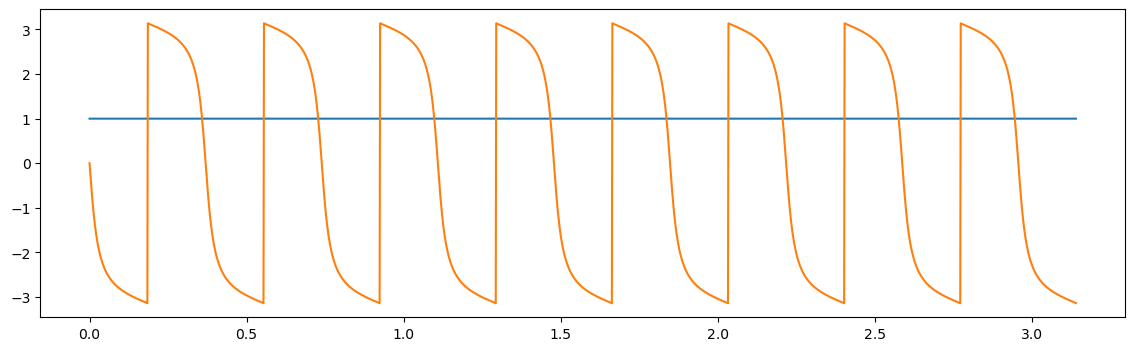

In [17]:
D, g = 17, 0.7
w, H = sp.freqz(*allpass(D, g), 2048);
plt.plot(w, np.abs(H));
plt.plot(w, np.angle(H));

#### Impulse Response

Next, we'll inspect the impulse response of the all-pass filter. The impulse response of an all-pass filter is also a spaced-out exponentially decaying sequence:

$$
    a[n] = \begin{cases}
        0 & n < 0,\\[5pt]
        -g & n = 0,\\[5pt]
        g^k (1-g^2) & n = kD,\quad k \in \mathbb{N},\\[5pt]
        0 & \text{otherwise.}
    \end{cases}
$$

We calculate and display the impulse response by filtering an impulse signal with our all-pass filter using `sp.lfilter`, and then visualize it using a stem plot:




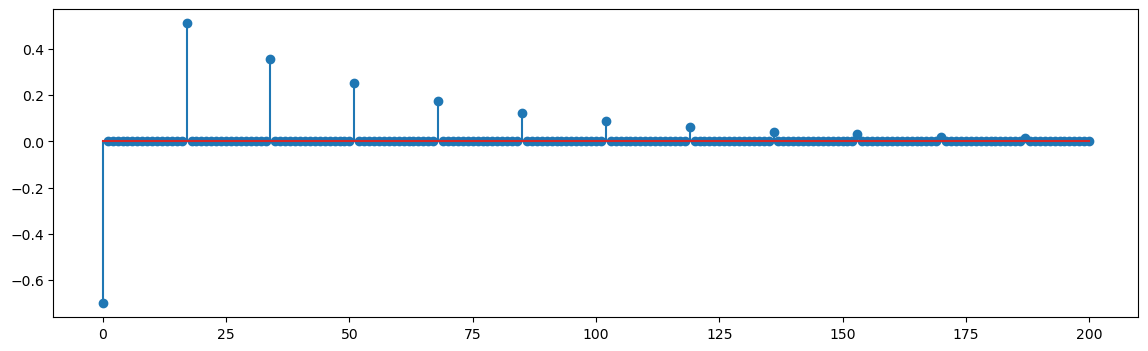

In [19]:
plt.stem(sp.lfilter(*allpass(D, g), np.r_[1, np.zeros(200)]));

#### Audio Visualisation
Let's load an impulse-like audio excerpt and see how an allpass filter can spread out the peak in time without affecting the acoustic properties too much:

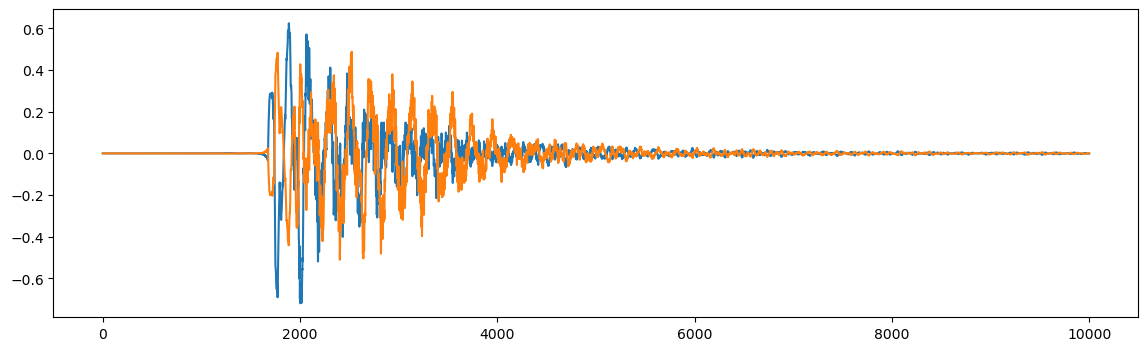

In [21]:
sf, snare = load_wav('snare')
snare = snare[:10000]

D, g = 210, 0.7
ap_snare = sp.lfilter(*allpass(D, g), snare);

plt.plot(snare);
plt.plot(ap_snare);

### Now, Let's Hear Our Creation!

After all the filtering and processing, it's time to listen to the final result.  
The first audio is the original and the second one is the outpout of the filter

In [ ]:
sf, audio = load_wav('The_end')
y = sp.lfilter(*allpass(int(sf * 0.08), 0.7), audio)

In [33]:
display(Audio(audio, rate=sf/2))
display(Audio(y, rate=sf))

---
### B) **Feedback Comb Filters**

A recursive echo can be modeled by a simple first-order IIR filter, often referred to as a **comb filter** because its magnitude response exhibits regularly-spaced peaks at frequencies that are multiples of $\omega_0 = 2\pi / D$. The transfer function of the filter is given by:

$$
    C(z) = \frac{1}{1 - g z^{-D}}
$$

which is stable for $|g| < 1$.

### Deriving the Filter Coefficients

To implement the comb filter, we express its transfer function in the standard form:

$$
    C(z) = \frac{B(z)}{A(z)} = \frac{b_0 + b_1 z^{-1} + \dots + b_D z^{-D}}{1 + a_1 z^{-1} + \dots + a_D z^{-D}}.
$$

Try to think on your own about the implementation and then click to see if you're correct.

<details>
<summary style="color: green; cursor: pointer; font-size: 1.5em;">Show Answer</summary>

1. **Numerator $B(z)$:**

   The numerator is the constant $1$. Therefore, we can write:

   $$
       B(z) = 1
   $$

   This implies:
   - $b_0 = 1$
   - $b_k = 0$ for all $k \geq 1$.

2. **Denominator $A(z)$:**

   The denominator is $1 - g z^{-D}$, which can be expressed as:

   $$
       A(z) = 1 + 0 \cdot z^{-1} + 0 \cdot z^{-2} + \dots - g \cdot z^{-D}.
   $$

   Thus:
   - $a_0 = 1$
   - $a_D = -g$
   - $a_k = 0$ for all other indices $k \neq 0$ and $k \neq D$.

</details>


#### **Exercise 2** : Implementation 

In [ ]:
#Your code 
def feedback_comb_filter(x, D, g):
     # If our filter is of the form.
     #             jw                 -jw              -jwM
     #    jw    B(e  )    b[0] + b[1]e    + ... + b[M]e
     # H(e  ) = ------ = -----------------------------------
     #             jw                 -jw              -jwN
     #          A(e  )    a[0] + a[1]e    + ... + a[N]e
     
     # Return the coefficients a and b.

    b = ...# YOUR CODE HERE #
    a = ...# YOUR CODE HERE #

    return b, a

In [ ]:
#Solution

def feedback_comb_filter(D, g):
     # If our filter is of the form.
     #             jw                 -jw              -jwM
     #    jw    B(e  )    b[0] + b[1]e    + ... + b[M]e
     # H(e  ) = ------ = -----------------------------------
     #             jw                 -jw              -jwN
     #          A(e  )    a[0] + a[1]e    + ... + a[N]e

     # Return the coefficients a and b.

    b = [1]
    a = np.r_[1, np.zeros(int(D) - 1), -g]

    return b, a

#### Visualizing the Frequency Response

Now we'll visualize the output by examining the frequency response of the comb filter. With parameters set to $D = 16$ and $g = 0.7$, we compute the filter's frequency response using `sp.freqz` and then plot the magnitude. This plot gives us a clear picture of how the comb filter affects different frequency components.


In [ ]:
D, g = 16, 0.7
w, H = sp.freqz(*feedback_comb_filter(D, g), 2048)
plt.plot(w, np.abs(H));

#### Visualizing the Impulse Response

Next, we'll inspect the impulse response of the comb filter. The impulse response of a comb filter is an exponentially decaying sequence where only one sample every $D$ is nonzero. It is defined as:

$$
    c[n] = \begin{cases} g^k & \text{if } n = kD,\quad k \in \mathbb{N} \\ 0 & \text{otherwise} \end{cases}
$$

We calculate and display the impulse response by filtering an arbitrary impulse signal with our comb filter using `sp.lfilter`, and then visualize it using a stem plot.

In [ ]:
plt.stem(sp.lfilter(*feedback_comb_filter(D, g), np.r_[1, np.zeros(100)]));

### Now, Let's Hear Our Creation!

After all the filtering and processing, it's time to listen to the final result.  
The first audio is the original and the second one is the outpout of the filter

In [ ]:
sf, audio = load_wav('The_end')
y = sp.lfilter(*feedback_comb_filter(int(sf * 0.1), 0.7), audio)
display(Audio(audio, rate=sf))
display(Audio(y, rate=sf))

### **Adjusting the Delays**

The hyperparameters defined for the **Schroeder Reverb** on the [Stanford website](https://ccrma.stanford.edu/~jos/pasp/Schroeder_Reverberators.html) were optimized for a sampling rate of **25 kHz**. However, when playing audio, the sampling rate is not always 25 kHz, so it is necessary to scale these hyperparameters proportionally to match the actual sampling rate.

Furthermore, the delays of the comb filters depend on the size of the room. To increase the density of early reflections, multiple comb filters are used in parallel, ensuring that the delay values are **coprime**. This guarantees that the nonzero portions of their impulse responses do not overlap in time.

#### **(Advanced) Description of our Scaling Function**

Many implementations of reverberation algorithms in the literature specify delay and gain values that have been carefully chosen to be coprime and to produce high-quality reverberation. Since these delay values are specified in samples, they inherently assume a specific sampling rate for the input signals. When adapting these designs to a different rate, it is essential to scale the delay values appropriately while preserving their coprimality.

In our examples, this is achieved by rounding the rate-adjusted delay values to the nearest prime number. This scaling function is critical for maintaining the desired reverberation quality and ensuring that early reflections remain well-distributed in time.


In [ ]:
def closest_primes(values, margin=1.5):
    values = np.array(values).astype(int)
    limit = int(np.max(values) * margin)

    # mark all prime numbers up to the limit using Eratosthenes sieve
    a = np.ones(limit).astype(bool)
    a[1] = a[::2] = False
    for i in range(3, int(np.sqrt(limit)) + 1):
        if a[i]:
            a[i*i::2*i] = False
    if not np.any(a[np.max(values):]):
        raise 'increase the top margin for prime search'

    vp = np.zeros_like(values)
    for ix, v in enumerate(values):
        # find neighboring primes (smaller and greater) and keep the closest
        vs = vg = v
        while not a[vs]:
            vs -= 1
        while not a[vg]:
            vg += 1
        vp[ix] = vs if np.abs(v - vs) < np.abs(v - vg) else vg   
        
    return vp

**Example of use** : Outpout an array with each values rounded up/down to the closest prime.

In [ ]:
closest_primes([3239, 3073, 3941, 4321])

## From the CCRMA Schematic to Our Simplified Implementation

The original **CCRMA** schematic :

<img width="700" style="display: block; margin: 20px auto;" src="img/schroeder_reverb_stanford.png"> 

 includes a **Mixing Matrix (MM)** block after four parallel **Feedback Comb Filters (FBCFs)**. This matrix allows for different weighting of each comb filter output, providing more control over how each comb filter contributes to the overall reverb.

However, in this simple example, we do not need that level of flexibility. Hence we can **replace the mixing matrix with a simple adder** that sums all comb filter outputs directly. Because the system is **linear**, swapping the order of the comb filters and the all-pass filters does not fundamentally change the result—this is due to the **commutative property** of linear operations. Essentially, the filters can be reordered without affecting the overall reverberation effect as long as no additional weighting factors (beyond unity) are introduced.

This finally give us this **simplified schematic* :

<img width="700" style="display: block; margin: 20px auto;" src="img/schroeder_simple.png"> 

The outputs of the four comb filters are added together and then passed through a series of **all-pass filters**. This design retains the essence of **Schroeder Reverb**—early reflections modeled by parallel comb filters, followed by diffusion from cascaded all-pass filters—but removes the extra complexity of a separate mixing matrix. By summing all comb filter outputs equally, you still achieve a rich reverb tail without the overhead of managing multiple weights in the mix.


### Implementing the Simplified Version with Original Parameters

We will now implement this simpler version of the Schroeder Reverb while **keeping the same filter parameters** used in the original design. 
  
#### **Exercise** : Your task is to
1. **Add these parameters** into your code.
2. **Construct the filter architecture** using the functions implemented earlier (e.g., comb filters, all-pass filters, and any necessary summation blocks).

By incorporating these parameters and connecting the filters as shown in the diagrams, you will recreate the simplified version of the Schroeder Reverb without the additional mixing matrix.


In [ ]:
def schroeder(x, sf, wet=0.2):
    # delays and gains for allpass and comb filters; these produce a reverb with RT60 of about 1 second
    #  and were proposed by John Chowning (CCRMA, Stanford)

    ##### YOUR CODE HERE #####

    AP1 = (347, 0.7) #First Allpass Filter
    AP2 = ...
    AP3 = ...

    CF1 = ...
    CF2 = ...
    CF3 = ...
    CF4 = ...

    DESIGN_SF = 25000  # filter delays are relative to this sampling rate
    
    ##### END OF YOUR CODE #####
    
    # Since those value are optimised for a specific sampling rate of 25 kHz,
    #  we need to adjust them to the current sampling rate
    AP = np.array([AP1, AP2, AP3]).T
    CF = np.array([CF1, CF2, CF3, CF4]).T
    # recompute delays wrt current sampling rate
    AP[0] = closest_primes(AP[0] * sf / DESIGN_SF)
    CF[0] = closest_primes(CF[0] * sf / DESIGN_SF)

    AP = AP.T
    CF = CF.T

    y = np.zeros_like(x)
    
    ##### YOUR CODE HERE #####
    for N, g in CF: #SUM OF COMB FILTERS
        ...
    
       
    for N, g in AP:  #CHAINING OF ALLPASS FILTERS
        ...
    ##### END OF YOUR CODE #####
    
    return wet * y + (1 - wet) * x

In [ ]:
#Solution
def schroeder(x, sf, wet=0.2):
    # delays and gains for allpass and comb filters; these produce a reverb with RT60 of about 1 second
    #  and were proposed by John Chowning (CCRMA, Stanford)

    ##### YOUR CODE HERE #####

    AP1 = (347, 0.7)
    AP2 = (113, 0.7)
    AP3 = (37, 0.7)

    CF1 = (1687, 0.773)
    CF2 = (1601, 0.802)
    CF3 = (2053, 0.753)
    CF4 = (2251, 0.733)

    DESIGN_SF = 25000  # filter delays are relative to this sampling rate
    
    ##### END OF YOUR CODE #####
    
    # Since those value are optimised for a specific sampling rate of 25 kHz,
    #  we need to adjust them to the current sampling rate
    AP = np.array([AP1, AP2, AP3]).T
    CF = np.array([CF1, CF2, CF3, CF4]).T
    # recompute delays wrt current sampling rate
    AP[0] = closest_primes(AP[0] * sf / DESIGN_SF)
    CF[0] = closest_primes(CF[0] * sf / DESIGN_SF)

    AP = AP.T
    CF = CF.T

    y = np.zeros_like(x)
    
    ##### YOUR CODE HERE #####
    
    for N, g in CF: #SUM OF COMB FILTERS
        y += sp.lfilter(*feedback_comb_filter(N, g), x) #
    
    
    for N, g in AP: #CHAINING OF ALLPASS FILTERS
        y = sp.lfilter(*allpass(N, g), y)

    ##### END OF YOUR CODE #####
    
    return wet * y + (1 - wet) * x

#### Visualization of our filter

In [ ]:
plt.plot(schroeder(np.r_[1, np.zeros(25000)], 25000, wet=0.5));

## Final Result: Listening to the Processed Audio

In [ ]:
sf, funk = load_wav('funk')
y = schroeder(funk, sf, wet=0.2)
display(Audio(funk, rate=sf))
display(Audio(y, rate=sf))

# **II BASS BOOST FILTER**

<img width="700" style="display: block; margin: 20px auto;" src="img/bass.jpg"> 

In the previous lab, we demonstrated a simple method to create a bass boost filter. Now, let's delve deeper into this concept with the help of this implementation guide. In particular, we can achieve a bass boost using a single low shelf filter.

For the remainder of this lab, we will base our work on Cookbook Formulae for Audio EQ Biquad Filter Coefficients by Robert Bristow-Johnson.

    "All filter transfer functions were derived from analog prototypes (that
    are shown below for each EQ filter type) and had been digitized using the
    Bilinear Transform. BLT frequency warping has been taken into account for
    both significant frequency relocation (this is the normal "prewarping" that
    is necessary when using the BLT) and for bandwidth readjustment (since the
    bandwidth is compressed when mapped from analog to digital using the BLT)."

This cookbook demonstrates how well-known analog filters are converted into the digital domain. Please refer to the diagram below to see how this process is accomplished.

Analog prototype : 

$$ H(s) = \frac{A\left(s^2 + \frac{\sqrt{A}}{Q}\,s + A\right)}{A\,s^2 + \frac{\sqrt{A}}{Q}\,s + 1} $$

We have :
$$
s \;\longleftarrow\; \text{continuous time}
$$

$$
z \;\longleftarrow\; \text{discrete time}
$$

We obtain $H(z)$ from the analog prototype : 

$$
H(z) = \frac{b_0 + b_1\,z^{-1} + b_2\,z^{-2}}
            {a_0 + a_1\,z^{-1} + a_2\,z^{-2}}
$$ 

Using the map going from $s$ to $z$ as follow : 
$$
\text{(normalized) } s \;\longleftarrow\; 
\frac{1}{\tan\Bigl(\frac{\omega_0}{2}\Bigr) } \frac{1 - z^{-1}}{1 + z^{-1}}
$$



##### This shows 6 coefficients instead of 5 so, depending on your architechture, you will likely normalize a0 to be 1 and perhaps also b0 to 1 (and collect that into an overall gain coefficient).  Then your transfer function would look like:

$$
H(z) = \frac{\frac{b_0}{a_0} + \frac{b_1}{a_0}\,z^{-1} + \frac{b_2}{a_0}\,z^{-2}}
            {1 + \frac{a_1}{a_0}\,z^{-1} + \frac{a_2}{a_0}\,z^{-2}}
$$

Hence we have :

$$ b = [\,b_0/a_0,\quad b_1/a_0,\quad b_2/a_0\,] $$
$$ a = [\,1,\quad a_1/a_0,\quad a_2/a_0\,]$$


## Calculating the filter coefficients for a low shelf 
A first step in this Cookbook is to define some intermediate coefficients common to most of the filters. These parameters are shared among the filter designs implemented in the provided paper. Calculating them only once not only reduces computation time but also improves the overall clarity of the implementation.

- $ Q = \frac{1}{\sqrt{2}} $

- $ w_0 = \frac{2 \pi f_0}{f_s} $
- $ A = 10^{\frac{gain}{40}} $
- $ \alpha = \frac{\sin(w_0)}{2Q} $
- $ c = \cos(w_0) $



In [ ]:
def intermediate_coeff(dBgain,cutoff,sf,Q):

    A = 10 ** (dBgain/40)
    w0 = 2 * np.pi * cutoff / sf
    c = np.cos(w0)
    alpha = np.sin(w0) / (2 * Q)

    return A, c, alpha

### a) Normalized final coefficients

As said before, a simple way to implement a bass booster filter is to use a second-order low-shelf filter, often referred to as a peaking equalizer (see: [Peaking Equalizers](https://ccrma.stanford.edu/~jos/filters/Peaking_Equalizers.html)). By fine-tuning its parameters, you can achieve the desired boosting effect.  
In this exercise, you can look up the implementation in the Cookbook and try to implement it directly; additionally, through online research you can find effective hyperparameter configurations to obtain a Bass Boost effect.

Below are the normalized coefficients for the filter's transfer function, as defined in the Cookbook:

- $ a_0 = (A + 1) + (A - 1) \cdot c + 2\sqrt{A} \cdot \alpha $  

- $a_1 = \frac{-2\left[(A - 1) + (A + 1) \cdot c\right]}{a_0} $  
- $ a_2 = \frac{(A + 1) + (A - 1) \cdot c - 2\sqrt{A} \cdot \alpha}{a_0}$

- $ b_0 = \frac{A\left[(A + 1) - (A - 1) \cdot c + 2\sqrt{A} \cdot \alpha\right]}{a_0}$
- $ b_1 = \frac{2A\left[(A - 1) - (A + 1) \cdot c\right]}{a_0}$
- $ b_2 = \frac{A\left[(A + 1) - (A - 1) \cdot c - 2\sqrt{A} \cdot \alpha\right]}{a_0}$

In [ ]:
def low_shelf_filter(sf, dBgain= 6.0, cutoff= 500, Q= 1/ np.sqrt(2)):
    A, c, alpha = intermediate_coeff(dBgain,cutoff,sf,Q)

    a0 =           (A+1) + (A-1) * c + 2 * np.sqrt(A) * alpha
    a1 = -2 *    ( (A-1) + (A+1) * c                       )
    a2 =           (A+1) + (A-1) * c - 2 * np.sqrt(A) * alpha
    b0 =      A *( (A+1) - (A-1) * c + 2 * np.sqrt(A) * alpha )
    b1 =  2 * A *( (A-1) - (A+1) * c                       )
    b2 =      A *( (A+1) - (A-1) * c - 2 * np.sqrt(A) * alpha )

    b = np.array([b0, b1, b2]) / a0
    a = np.array([1, a1/a0, a2/a0])

    return b,a


## **Listening and Visualizing the Filter Output**

In this section, we will first plot the filter's response and then listen to the filtered audio. You can tweak the following parameters to see their impact:
- **dBgain**  *(dB gain for BassBoost)*
- **f0**      *(Cutoff frequency)*
- **Q**       *(Quality factor)*

Try to reflect on what values these hyperparameters should take in order to implement an effective Bass Boost. For example, a higher dBgain might be used to increase the bass levels, while a lower f0 ensures that only the low-frequency components are boosted. The quality factor Q will influence the steepness and smoothness of the boost, balancing between a broad, subtle effect and a sharp, pronounced peak.

In [ ]:
#Exemple of values.
dBgain = 12         # gain for BassBoost
f0 = 300            # Cutoff frequency (Hz) 
Q = 1 / np.sqrt(2)  # Quality factor

b, a = low_shelf_filter(sf,dBgain, f0, Q)

#### **Step 1:** Plot the filter's response.
This function can help you plot the frequency response of the filter you just created.

In [ ]:
def plot_frequency_response(H,w, f0=None, label="Filter Response", title="Frequency Response"):
    """
    Parameters:
    - H : array_like
        Frequency response (complex values), typically obtained from scipy.signal.freqz().
    - w : array_like
        Frequencies corresponding to H, in Hz.
    - f0 : float, optional
        Optional cutoff frequency to mark with a vertical dashed line (in Hz).
    """
    plt.figure(figsize=(8, 4))
    plt.semilogx(w, 20 * np.log10(np.abs(H)), label=label)
    
    if f0 is not None:
        plt.axvline(f0, color='r', linestyle='--', label=f"Cutoff Frequency (f0 = {f0} Hz)")
    
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Gain (dB)")
    plt.legend()
    plt.grid()
    plt.show()

Let's see what it looks like.

In [ ]:
w, H = sp.freqz(b, a, worN=4096, fs=sf)
plot_frequency_response(H,w, f0=f0)

**Exercise: Frequency Response Verification via Impulse Response DFT**

Compute your filter’s impulse response using an impulse signal, then apply the Discrete Fourier Transform (DFT) to it. Finally, compare this DFT-derived frequency response with the analytical frequency response (e.g., from `sp.freqz`).

What do you observe ? 

In [ ]:
def impulse_response(n, f0, sf, Q, dBgain):
    """
    Compute the impulse response h[n] of a low-shelf filter over n samples.
    
    Parameters:
        n (int): Number of samples in the impulse response.
        f0 (float): Cutoff frequency (Hz) for the low-shelf filter.
        sf (float): Sampling frequency (Hz).
        Q (float): Quality factor of the filter.
        dBgain (float): Gain of the filter
    
    Returns:
        h (np.array): The impulse response computed by filtering an impulse with the low-shelf filter.
    """
    
    # Calculate filter coefficients for the low-shelf filter
    b, a = low_shelf_filter(sf, dBgain, f0, Q)
    h = np.zeros(n)

    #### YOUR CODE HERE ####
    
    return h

In [ ]:
f0 = 1000       # Cutoff frequency in Hz
sf = 44100      # Sampling frequency in Hz
Q = 0.707       # Quality factor
n = 256         # Length of the impulse response
dBgain = 12.0   # Gain of the filter
n_fft = 8000    # Unified length in frequency domain.

#### YOUR CODE HERE ####

In [ ]:
#SOLUTION
def impulse_response(n, f0, sf, Q, dBgain):
    """
    Compute the impulse response h[n] of a low-shelf filter over n samples.
    
    Parameters:
        n (int): Number of samples in the impulse response.
        f0 (float): Cutoff frequency (Hz) for the low-shelf filter.
        sf (float): Sampling frequency (Hz).
        Q (float): Quality factor of the filter.
        dBgain (float): Gain of the filter
    
    Returns:
        h (np.array): The impulse response computed by filtering an impulse with the low-shelf filter.
    """
    
    # Calculate filter coefficients for the low-shelf filter
    b, a = low_shelf_filter(sf, dBgain, f0, Q)
    
    # Create the impulse signal: x[0]=1, x[1:]=0
    x = np.zeros(n)
    x[0] = 1.0
    h = np.zeros(n)
    
    # Compute the impulse response using the difference equation
    for i in range(n):
        # Apply feedforward part
        for j in range(len(b)):
            if i - j >= 0:
                h[i] += b[j] * x[i - j]
        # Apply feedback part
        for j in range(1, len(a)):
            if i - j >= 0:
                h[i] -= a[j] * h[i - j]
    return h

In [ ]:
#SOLUTION
f0 = 1000       # Cutoff frequency in Hz
sf = 44100      # Sampling frequency in Hz
Q = 0.707       # Quality factor
n = 256         # Length of the impulse response
dBgain = 12.0   # Gain of the filter
n_fft = 8000    # Unified length in frequency domain.

b, a = low_shelf_filter(sf, dBgain, f0, Q)
h = impulse_response(n, f0, sf, Q, dBgain)
# Compute frequency response by taking the FFT of the impulse response

H_impulse = np.fft.rfft(h, n=n_fft)
# Create frequency axis (rfft returns frequencies from 0 to sf/2)
# f_fft = np.linspace(0, sf/2, len(H_impulse))

# Compute frequency response using freqz from filter coefficients
w, H_filter = sp.freqz(b, a, worN=n_fft//2 +1, fs=sf)  # w in Hz


# Plot the frequency response from the pre-designed filter
plot_frequency_response(H_filter, w, f0=f0, label="Filter Response (freqz)",
                            title="Frequency Response Comparison")

# Plot the frequency response obtained from the FFT of the impulse response
plot_frequency_response(H_impulse, w, f0=f0, label="Impulse Response FFT",
                            title="Frequency Response Comparison")

**Exercise :**
Plot the frequency response of the implemented filter to visualize how different hyperparameters affect the bass boost effect, allowing you to fine-tune them.
Use the provided sample values or add your own values.
- f₀: [100, 1000, 5000] Hz
- Q: [0.1, 0.5, 1/√2, 0.8, 1.0]
- dB gain: [-12.0, 0.1, 12.0, 40.0]  

Use this function to verify that it's return impulse response match the frequency response of the pre-disign filter.
Hint : You might want to use the previously declared function to plot it.

In [ ]:
f0s = [100, 1000, 5000]                                 # f0 (Hz)
Q_factor = [0.1, 0.5, 1/np.sqrt(2),0.8, 1.0]            # Quality factor Q
gains = [-12.0, 0.1, 12.0, 40.0]                        # dBgain (dB)

#### YOUR CODE HERE ####


In [ ]:
#Solution.
f0s = [100, 1000, 5000]                                 # f0 (Hz)
Q_factor = [0.1, 0.5, 1/np.sqrt(2),0.8, 1.0]            # Quality factor Q
gains = [-12.0, 0.1, 12.0, 40.0]                        # dBgain (dB)
default_f0 = 1000

#### YOUR CODE HERE ####

# Variation of Cutoff Frequency (f0)
print("###### Cutoff Frequency ######")
for f in f0s:
    b, a = low_shelf_filter(sf, cutoff=f)
    w, H = sp.freqz(b, a, worN=8000, fs=sf)  # w in Hz
    title_str = f"Frequency Response: f0 = {f} Hz (Cutoff Frequency)"
    label_str = f"Filter Response (freqz) - f0 = {f} Hz"
    plot_frequency_response(H, w, f0=f, label=label_str, title=title_str)

# Variation of the Quality Factor (Q)
print("###### Q Factor ######")
for q in Q_factor:
    b, a = low_shelf_filter(sf, Q=q, cutoff=default_f0)
    w, H = sp.freqz(b, a, worN=8000, fs=sf)  # w in Hz
    title_str = f"Frequency Response: Q = {q}"
    label_str = f"Filter Response (freqz) - Q = {q}"
    plot_frequency_response(H, w, f0=default_f0, label=label_str, title=title_str)

# Variation of the Gain (dBgain)
print("###### dBgain ######")
for g in gains:
    b, a = low_shelf_filter(sf, dBgain=g, cutoff=default_f0)
    w, H = sp.freqz(b, a, worN=8000, fs=sf)  # w in Hz
    title_str = f"Frequency Response: dBgain = {g} dB"
    label_str = f"Filter Response (freqz) - dBgain = {g} dB"
    plot_frequency_response(H, w, f0=default_f0, label=label_str, title=title_str)


#### **Step 2:** Listen to the filtered audio.

***Note:** When listening, you might notice that the overall sound level seems to have changed. This is due to the normalization of the audio signal between -1 and 1, which can reduce the volume, as seen in this example.*

In [ ]:
sf, x = load_wav('groove')
x = x.astype(np.float32)
display(Audio(x, rate=sf))

y =  sp.lfilter(*low_shelf_filter(sf, dBgain=20.0,cutoff=200), x)

display(Audio(y, rate=sf))

# Spectrogram Analysis of Filtered Audio Signal

As we have experienced during listening, the overall audio level is generally attenuated, while the bass frequencies are distinctly boosted. This effect is the result of the filter's design and normalization process.

### Visualizing the Effect with Spectrograms

A spectrogram allows you to see the magnitude of a signal across both time and frequency. 

- **Bright Colors:** Indicate magnitudes closer to the maximum dB level of the signal.
- **Dark Colors:** Reflect lower magnitude values in the frequency spectrum.

For clarity and direct comparison, both the pre-filter and post-filter spectrograms are displayed using the same dynamic range. This ensures that any changes in the spectral content, such as the enhancement of bass frequencies and overall level adjustments, are easily observable.

In [ ]:
#FUNCTION TO PLOT THE SPECTROGRAM (NO CHANGES NEEDED)

def compute_spectrogram(signal, sf):
    # Compute the spectrogram
    f, t, Sxx = sp.spectrogram(signal, sf, nperseg=1024, noverlap=512)
    # Remove 0 value problem for log scale
    Sxx[Sxx == 0] = np.min(Sxx[Sxx > 0])
    Sxx_dB = 10 * np.log10(Sxx)
    return f, t, Sxx_dB

def plot_spectrogram(initial_signal, filtered_signal, sf, title_orig, title_filt, limit_freq= 20000):


    f_o, t_o, Sxx_dB_o = compute_spectrogram(initial_signal, sf)
    f_f, t_f, Sxx_dB_f = compute_spectrogram(filtered_signal, sf)
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))

    min = np.min([Sxx_dB_o, Sxx_dB_f])

    ax[0].pcolormesh(t_o, f_o, Sxx_dB_o, shading='auto', vmin=min, vmax=0)
    ax[0].set_title(title_orig)
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Frequency (Hz)")
    ax[0].set_ylim(20, limit_freq)  # Focus on a specific frequency range (e.g., bass)

    mappable = ax[1].pcolormesh(t_f, f_f, Sxx_dB_f, shading='auto', vmin=min, vmax=0)
    ax[1].set_title(title_filt)
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Frequency (Hz)")
    ax[1].set_ylim(20, limit_freq)  # Focus on a specific frequency range (e.g., bass)

    # Add colorbar
    plt.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.12, 0.02, 0.75])
    cbar = fig.colorbar(mappable, cax=cbar_ax, label="Magnitude (dB)")
    plt.show()

In [ ]:
# Plot both spectrograms using the same dB range
plot_spectrogram(x, y, sf, "Original Signal Spectrogram", "Filtered Signal Spectrogram", limit_freq=2000)

# **III SWEEP EQ EFFECT**

<img width="700" style="display: block; margin: 20px auto;" src="img/dj.jpg"> 

##### Now that we know how to use this cookbook, we can implement additional filters and combine them with those we’ve already applied. One effect we can simulate in audio mixing is **Sweeping EQ** : The main idea behind this technique is to gradually remove frequencies, starting from the lowest ones and progressing toward the higher ones to build tension. Once the bass is completely eliminated, another track is seamlessly introduced to create a smooth transition.

##### Exercise : To do so, we will first implement a High/Low pass filter of second order. Your function should return the coefficient arrays a[] and b[], ensuring that the filter is of second order.
* One can notice that the distinction between a low-pass filter and a high-pass filter can be made very simply.  
By convention, the argument `filter_type` takes the value `Low` for a low-pass filter and `High` for a high-pass filter.


In [ ]:
def pass_coeff(cutoff, sf, Q = 1 / np.sqrt(2), filter_type='High'):
    #YOUR CODE HERE
    ...
    return b,a

In [ ]:
#Solution
def pass_coeff(cutoff, sf, Q = 1 / np.sqrt(2), filter_type = 'High'):

    _,c,alpha = intermediate_coeff(dBgain= 1, cutoff= cutoff, sf= sf, Q= Q)

    m = -1 if filter_type.lower() == 'low' else 1

    b0 =  (1 + m * c)/2
    b1 = -(m  + c)
    b2 =  b0

    a0 =   1 + alpha
    a1 =  -2*c
    a2 =   1 - alpha
    
    b = np.array([b0, b1, b2]) / a0
    a = np.array([1, a1/a0, a2/a0])

    return b, a

# Plotting Filter Frequency Responses

The goal of this example is to visualize the frequency responses for both a high-pass and a low-pass filter using our `pass_coeff` function.

We use the `scipy.signal.freqz()` function to compute the frequency response of each filter. You can read more about it in the [Scipy.signal.freqz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html) documentation and example of use

In [ ]:
def visualize_filters(cutoff, sf, Q=1/np.sqrt(2)):
    # Compute filter coefficients for both high-pass and low-pass filters
    b_high, a_high = pass_coeff(cutoff, sf, Q, filter_type='High')
    b_low, a_low = pass_coeff(cutoff, sf, Q, filter_type='Low')
    
    ##### YOUR CODE HERE ######
    ...


In [ ]:
#SOLUTION
def visualize_filters(cutoff, sf, Q=1/np.sqrt(2)):
    # Compute filter coefficients for both high-pass and low-pass filters
    b_high, a_high = pass_coeff(cutoff, sf, Q, filter_type='High')
    b_low, a_low = pass_coeff(cutoff, sf, Q, filter_type='Low')
    

    w, h_high = sp.freqz(b_high, a_high, worN=8000, fs=sf)
    _, h_low = sp.freqz(b_low, a_low, worN=8000, fs=sf)

    #Small epsilon to avoid log(0)
    epsilon = 1e-8
    

    plt.figure()
    plt.plot(w, 20 * np.log10(np.maximum(np.abs(h_high), epsilon)), label='High-pass')
    plt.plot(w, 20 * np.log10(np.maximum(np.abs(h_low), epsilon)), label='Low-pass')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.title('Frequency Response of High-pass and Low-pass Filters')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
cutoff = 2000  # cutoff frequency in Hz
sf = 41000     # sampling frequency in Hz
visualize_filters(cutoff, sf)

#### Chaining High-Pass Filters to make the sweep effect.

Finally, you can listen to what happens when you chain several high-pass filters sequentially, each with an increasing cutoff frequency, to gradually reduce the low-frequency content. Then, the same audio is reintroduced with boosted bass, simulating this transition, well-known from the clubbers. Play the audio to hear the result.

In [ ]:
def filter_sweep(x, times, values,sf):
    # filter the input with a filter whose parameter at every instant n is the linear interpolation 
    #  between successive (time, value) pairs
    N = len(x)
    times = np.minimum(np.array(times) * sf, N).astype(int)  # convert to samples
    times, values = np.r_[ times, N ], np.r_[ values, values[-1] ]  # add endpoints
    
    b, a = pass_coeff(values[0], sf)    # filter buffers
    buf = np.zeros((2, max(len(a), len(b))))
    
    y = np.zeros(N)
    for k in range(1, len(times)):
        for n in range(times[k-1], times[k]):
            c = (times[k] - n) / (times[k] - times[k-1])
            param = c * values[k-1] + (1-c) * values[k]
            if param > 0:
                b, a = pass_coeff(param, sf)
            else:
                b, a = np.array([1, 0, 0]), np.array([1, 0, 0])
            buf[:,0] = [x[n], 0]
            y[n] = buf[1][0] = b @ buf[0] - a @ buf[1]
            buf = np.roll(buf, 1, axis=1)
    return y

In [ ]:
sf, x = load_wav('groove')

drop = filter_sweep(x, [0, 7.5, 10, 14], [0, 0, 500, 2500], sf=sf) 
drop *= np.linspace(1, 3, len(drop))

In [ ]:
bassy = sp.lfilter(*low_shelf_filter(sf,12, 300, 1 / np.sqrt(2)), x)
bassy = filter_sweep(bassy, [0, 4, 6.5, 14], [2500, 500, 0, 0], sf=sf)
bassy *= np.linspace(1, 1.5, len(bassy))

In [ ]:
Audio(np.r_[ drop, bassy ], rate=sf)

Thank you for working through this lab. We hope you found it informative and enjoyable!